In [1]:
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

import ast

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# read data
df_train = pd.read_csv('../data/twitter/train_processed.csv', encoding='latin-1')
df_train['processed_text'] = df_train['processed_text'].apply(lambda x: ast.literal_eval(x))

df_test = pd.read_csv('../data/twitter/test_processed.csv', encoding='latin-1')
df_test['processed_text'] = df_test['processed_text'].apply(lambda x: ast.literal_eval(x))

In [3]:
df_train.head()

,target,text,processed_text
0,1,killing me softly with his words,"[killing, softly, word]"
1,1,@drnicomartini Check it. Passion Pit at the Gr...,"[check, passion, pit, granada, last, night]"
2,1,Coffee is so good when you can sit and drink i...,"[coffee, good, sit, drink, watch, ur, kid, pla..."
3,0,wants to go and see &quot;my sisters keeper&qu...,"[want, go, see, quotmy, sister, keeperquot, lo..."
4,1,I think I'm going to take a hot bath &amp; lis...,"[think, im, going, take, hot, bath, amp, liste..."


In [4]:
# download word2vec model: use best-performing one based on qualitative evaluation
w2v_model = Word2Vec.load('./models/word2vec/skipgram_128_15_15.model')

In [5]:
# use word2vec to vectorize each token, and create sentence embeddings by averaging word vectors of one sentence
def get_sentence_embedding(tokens):
    vectors = []
    for token in tokens:
        if token in w2v_model.wv:
            vectors.append(w2v_model.wv[token])
    
    return np.mean(vectors, axis=0)
        

df_train['sentence_embeddings'] = df_train['processed_text'].apply(get_sentence_embedding)
df_test['sentence_embeddings'] = df_test['processed_text'].apply(get_sentence_embedding)

c:\Users\yjiah\Downloads\natural-language-processing\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yjiah\Downloads\natural-language-processing\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\yjiah\Downloads\natural-language-processing\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yjiah\Downloads\natural-language-processing\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
df_train.head()

,target,text,processed_text,sentence_embeddings
0,1,killing me softly with his words,"[killing, softly, word]","[0.082838185, -0.2889227, 0.10171181, 0.096939..."
1,1,@drnicomartini Check it. Passion Pit at the Gr...,"[check, passion, pit, granada, last, night]","[0.06995579, -0.42072287, 0.20488566, 0.112381..."
2,1,Coffee is so good when you can sit and drink i...,"[coffee, good, sit, drink, watch, ur, kid, pla...","[0.14163932, -0.4468178, 0.26025906, 0.1681035..."
3,0,wants to go and see &quot;my sisters keeper&qu...,"[want, go, see, quotmy, sister, keeperquot, lo...","[0.09060944, -0.45969784, 0.19226779, 0.114756..."
4,1,I think I'm going to take a hot bath &amp; lis...,"[think, im, going, take, hot, bath, amp, liste...","[0.13507445, -0.42727476, 0.2546147, 0.2091565..."


In [7]:
# drop NA values because there are some text which are empty lists after processing
df_train = df_train.dropna()
df_test = df_test.dropna()

# split data into train and test
X_train = np.vstack(df_train['sentence_embeddings'].values)
X_test = np.vstack(df_test['sentence_embeddings'].values)
y_train = df_train['target']
y_test = df_test['target']

### Random Forest Classifier

In [8]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
def evaluate_model(y_test, y_pred):
    # Accuracy
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Classification report (precision, recall, f1)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 0.6841839312784235
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1010
           1       0.69      0.64      0.66       969

    accuracy                           0.68      1979
   macro avg       0.68      0.68      0.68      1979
weighted avg       0.68      0.68      0.68      1979



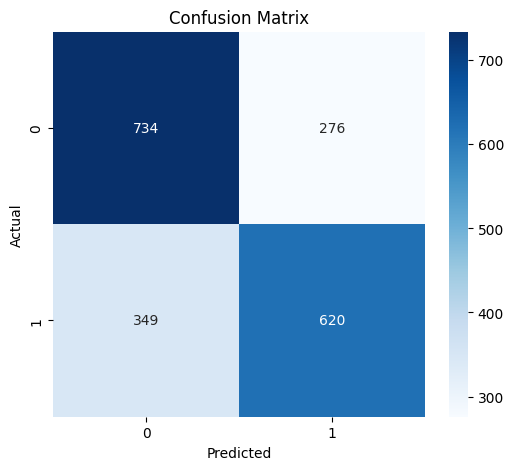

In [10]:
# evaluate on test set
y_pred = clf.predict(X_test)

evaluate_model(y_test, y_pred)

### Logistic Regression

In [11]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Accuracy: 0.6927741283476503
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1010
           1       0.69      0.69      0.69       969

    accuracy                           0.69      1979
   macro avg       0.69      0.69      0.69      1979
weighted avg       0.69      0.69      0.69      1979



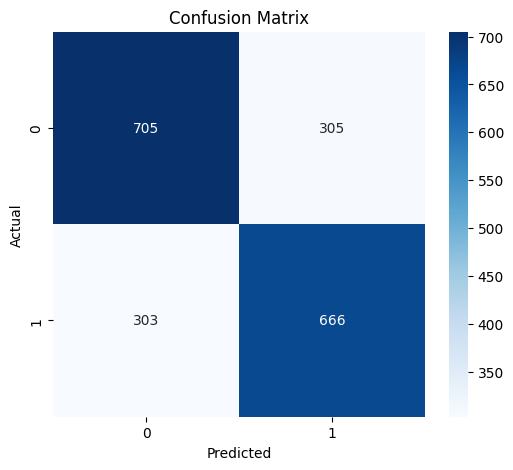

In [12]:
# evaluate on test set
y_pred = clf.predict(X_test)

evaluate_model(y_test, y_pred)

Logistic Regression performs slightly better on the skip-gram embeddings compared to Random Forest